# **Lab ML for Data Science: Part 3** | Getting Insights into Images and their Metadata

> Group: **BCK** - Prajna Narayan Bhat, Neeraj Omprakash Chauhan, Akash Skaria Koottungal

In [1]:
#importing necessary packages
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import roc_auc_score
import random
from collections import Counter
import matplotlib
import cv2
import torch.nn as nn
import torch.nn.functional as F


from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform1 = transforms.Compose([
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0, 0, 0],
                                [1, 1, 1])
                                ])


## 1. The Dataset

- Dataset: [Identification of Plant Leaf Diseases Using a 9-layer Deep Convolutional Neural Network](https://data.mendeley.com/datasets/tywbtsjrjv/1)
- Classes used: *“apple-healthy”* and *“apple-black-rot”*

In [4]:
dataset = datasets.ImageFolder('/content/drive/MyDrive/Plant Leaf/Diseases/Plant/Without Augmentation', transform=transform1)

In [5]:
dataset.class_to_idx

{'Apple___Black_rot': 0, 'Apple___healthy': 1}

In [6]:
print(dict(Counter(dataset.targets)))

{0: 621, 1: 1735}


In [42]:
selected_indices = np.concatenate((np.arange(0,100),np.random.randint(900,1000,100)))

In [44]:
# Shuffle the selected indices

random.shuffle(selected_indices)

train_split = int(0.8 * len(selected_indices))

# Split the dataset into training, validation, and test sets
train_indices = selected_indices[:train_split]
test_indices = selected_indices[train_split:]

# Create subsets
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# Create DataLoaders
batch_size = 32
# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


In [45]:
# Combine the loaders into a dictionary for ease of use in training
dataloaders = {'train': train_loader, 'test':test_loader}

In [46]:
class_names = dataset.classes
dataset.class_to_idx

{'Apple___Black_rot': 0, 'Apple___healthy': 1}

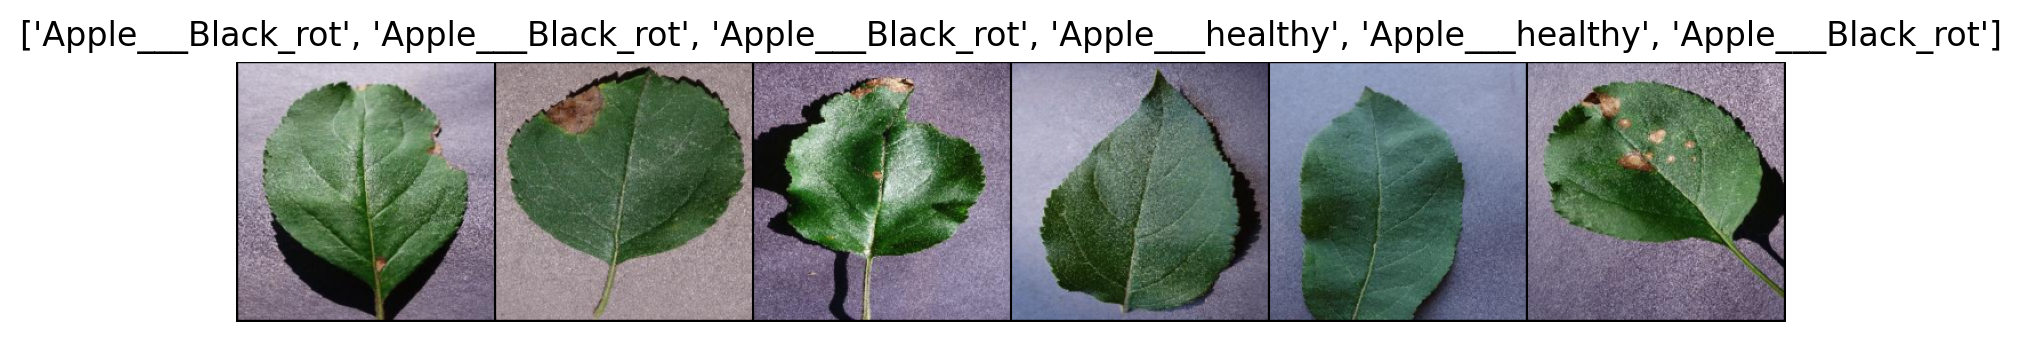

In [52]:
def imshow(inp, title=None):
    #inp = inv_transform(inp)
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:6])
    imshow(out, title=[class_names[x] for x in classes[:6]])

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs,classes)

## 2. Pretrained Models for Image Recognition

In [53]:
#importing the pretrained VGG16 network
model = models.vgg16(pretrained=True)
num_classes = len(dataset.classes)  # Set this to the number of classes in your new dataset

model = model.features
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [55]:
# Function to extract features
def extract_features(loader, model, device):
    features = torch.tensor([])
    labels = torch.tensor([])
    with torch.no_grad():
        for inputs, target in loader:
            inputs = inputs.to(device)
            output = model(inputs)
            #output = output.view(output.size(0), -1)
            features = torch.cat((features.to(device),output.to(device)))
            labels = torch.cat((labels,target))
            #features.append(output)
            #labels.append(target)
    return features,labels #np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_loader, model, device)
test_features, test_labels = extract_features(test_loader, model, device)

## 3. Predicting Classes from Images

- Applying *difference of means* to discriminate between two classes.
- Computing mean for the two classes in feature space:
$$
\small
𝞵_1 = \frac{1}{|C_1|}∑_{iϵC_1} 𝚽(x_i) \\
\small
𝞵_2 = \frac{1}{|C_2|}∑_{iϵC_2} 𝚽(x_i)
$$

- Computing the direction of the difference of means:
$ w = \large \frac{𝞵_2 - 𝞵_1}{\|𝞵_2 - 𝞵_1\|}$

- The discriminant function obtained:
$ \small g(x) = w^T𝚽(x) $


In [56]:
#discriminant function
def get_score(results, w):

# Flatten the tensor
  flattened_results = results.view(len(results), -1)
# Flatten the direction tensor w
  flattened_w = torch.flatten(w).to(device)
  g = torch.matmul(flattened_results, flattened_w)
  return g

In [57]:
Φ_C1 = train_features[train_labels==0] #feature set of label=0 images
Φ_C2 = train_features[train_labels==1] #feature set of label=1 images

μ1 = torch.mean(Φ_C1, dim=0)           #mean of feature set 1
μ2 = torch.mean(Φ_C2, dim=0)           #mean of feature set 2

w = μ2 - μ1
w /= torch.norm(w)


In [58]:
g_class_1 = get_score(Φ_C1, w)
g_class_2 = get_score(Φ_C2, w)

print(f'Score for the heatlhy class: {torch.mean(g_class_1):.3f}')
print(f'Score for the rot class: {torch.mean(g_class_2):.3f}')

Score for the heatlhy class: -32.578
Score for the rot class: 1.238


In [59]:
# Project data onto the discriminant direction for validation set
train_projections = get_score(train_features,w.clone().detach())

# Determine class membership based on projections
train_predictions = (train_projections.cpu().detach().numpy() > 0).astype(int)  # Assuming positive projections indicate class 2

# Calculate accuracy for validation set
train_accuracy = np.mean(np.array(train_predictions) == np.array(train_labels))
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')

# Calculate AUC for validation set
train_auc = roc_auc_score(train_labels, train_projections.cpu())
print(f'Train AUC: {train_auc:.2f}')

# Project data onto the discriminant direction for test set
test_projections = get_score(test_features,w.clone().detach())

# Determine class membership based on projections
test_predictions = (test_projections.cpu().detach().numpy() > 0).astype(int)  # Assuming positive projections indicate class 2

# Calculate accuracy for test set
test_accuracy = np.mean(np.array(test_predictions) == np.array(test_labels))
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Calculate AUC for test set
test_auc = roc_auc_score(test_labels, test_projections.cpu())
print(f'Test AUC: {test_auc:.2f}')


Train Accuracy: 81.88%
Train AUC: 1.00
Test Accuracy: 75.00%
Test AUC: 0.98


In [60]:
print(f'Class \t \t #Train \t \t #Test')
print(f'healthy \t \t {len(train_projections[train_predictions == 0])} \t \t {len(test_projections[test_predictions == 0])}')
print(f'blackrot \t \t {len(train_projections[train_predictions == 1])} \t \t {len(test_projections[test_predictions == 1])}')

Class 	 	 #Train 	 	 #Test
healthy 	 	 108 	 	 31
blackrot 	 	 52 	 	 9


## 4. Understanding the Image-Class Relation Pixel-Wise

### 4.1 Sensitivity Analysis

- Collection of Pixel-wise scores obtained by:  $(Sᵢ)_{i=1}^d = \|\frac{∂g}{∂xᵢ}\|^2$
- Aim: To highlight important features leading to prediction

In [61]:
def plot_image_sensitivity(image,w,model):
  image = image.to(device)
  image.requires_grad = True
  output = model(image)
  score = get_score(output,w.clone().detach())
  gradients = torch.autograd.grad(score, image)[0]
  gradients = gradients.squeeze()

  importance_scores = gradients.norm(dim=0) ** 2
  #normalize
  importance_scores = (importance_scores-importance_scores.min())/(importance_scores.max()-importance_scores.min())

  heatmap = importance_scores.cpu().detach().numpy()

  cmap = matplotlib.colormaps.get_cmap('autumn').copy()
  cmap.set_under(color='White')


  fig = plt.figure(figsize=(5, 5))
  plt.subplot(1,2,1)
  plt.imshow(heatmap, cmap=cmap, vmin=(importance_scores.std()))
  plt.title("Heatmap of the image")
  plt.axis('off')

  plt.subplot(1,2,2)
  #inv_transform(image)
  plt.imshow(image.squeeze().detach().cpu().numpy().transpose(1, 2, 0))
  plt.title("Original Image")
  plt.axis('off')

  plt.show()

In [62]:
inputs, classes = next(iter(dataloaders['test']))
ips, labels = inputs.to(device), classes.to(device)

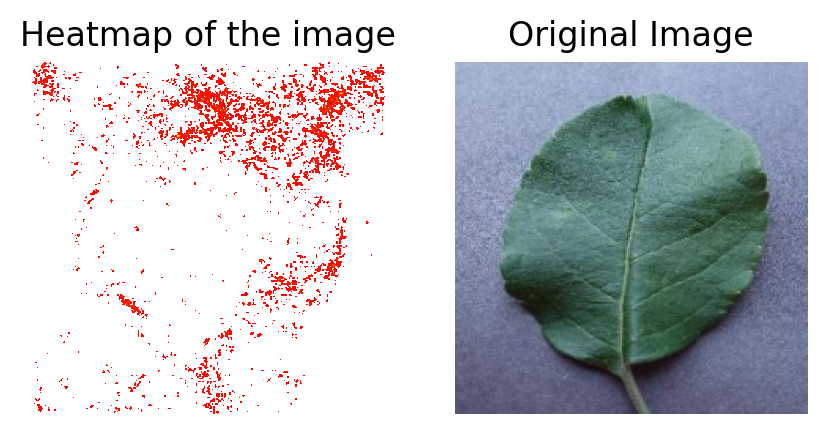

In [63]:
#select a random image from the dataset
image = ips[2].unsqueeze(0)

plot_image_sensitivity(image,w,model)

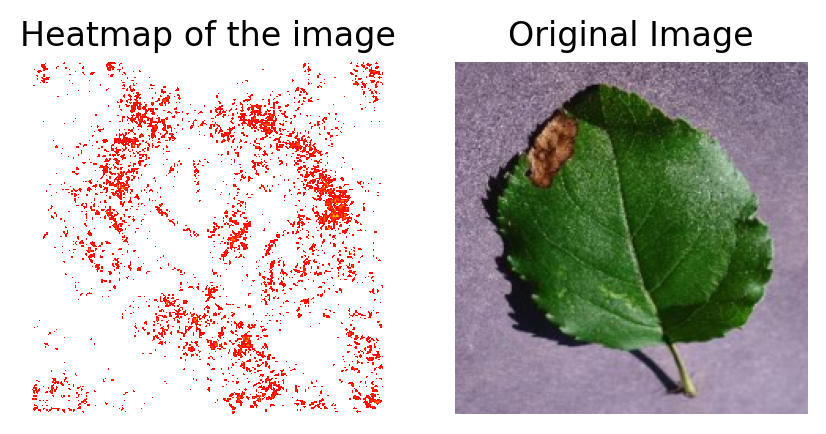

In [64]:
#Select a specific image from the dataset
img = cv2.imread('/content/drive/MyDrive/Plant Leaf/Diseases/Plant/Without Augmentation/Apple___Black_rot/image (127).JPG')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert NumPy array to PIL image
img_pil = Image.fromarray(img_rgb)
inp_img = transform1(img_pil)
inp_img = inp_img.unsqueeze(0)

plot_image_sensitivity(inp_img,w,model)

### 4.2 More Robust Explanations

- Aim: Robustifying gradient-based explanations
- Representation of a layer in neural network: $ z_k = ∑_j a_jw_{jk} + b_k $
- Generating a locally functional layer: $ z_k = (∑_j a_jw_{jk}^⇑ + b_k^⇑) · \left[\frac{∑_j a_jw_{jk} + b_k}{∑_j a_jw_{jk}^⇑ + b_k^⇑}\right]_{cst.}$
- Here,
$$
\small
w_{jk}^⇑ = w_{jk} + 0.25max(0,w_{jk}) \\
\small
b_k^⇑ = b_k + 0.25max(0,b_k)
$$

In [66]:
class BiasedLayer(nn.Module):
    def __init__(self, original_layer):
        super(BiasedLayer, self).__init__()
        self.original_layer = original_layer
        self.bias_factor = 0.25

    def forward(self, x):
        w = self.original_layer.weight
        b = self.original_layer.bias

        x_regular = self.original_layer(x)



        w_biased = w + self.bias_factor * torch.relu(w)
        b_biased = b + self.bias_factor * torch.relu(b) if b is not None else None

        if isinstance(self.original_layer, nn.Conv2d):
          x_modified = F.conv2d(x, w_biased, b_biased, stride=self.original_layer.stride, padding=self.original_layer.padding, dilation=self.original_layer.dilation, groups=self.original_layer.groups)
        elif isinstance(self.original_layer, nn.Linear):
          x_modified = F.linear(x,w_biased,b_biased)

        detatched = ((x_regular)/(x_modified)).detach()
        x = x_modified * detatched

        return x

In [67]:

def apply_biased_layers(model):
    layers_to_replace = []

    # Collect the layers to replace
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and name not in ['features.0', 'classifier.6']:
            layers_to_replace.append((name, module))

    # Replace the collected layers with BiasedLayer
    for name, module in layers_to_replace:
        parent_module, child_name = name.rsplit('.', 1)
        parent = dict(model.named_modules())[parent_module]
        setattr(parent, child_name, BiasedLayer(module))

    return model

# Load the pretrained VGG-16 model
from torchvision import models
model_new = models.vgg16(pretrained=True)

print(model_new)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [68]:
# Apply the BiasedLayer to the model
model_new = apply_biased_layers(model_new)
model_new.to(device)

# Verify that the BiasedLayer has been applied
print(model_new)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BiasedLayer(
      (original_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BiasedLayer(
      (original_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): BiasedLayer(
      (original_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): BiasedLayer(
      (original_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (11): ReLU(inplace=True)
    (12): BiasedLayer(
      (original_layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [69]:
model_new = model_new.features
model_new.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (original_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (original_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (original_layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (original_layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (11): ReLU(inplace=True)
  (12): BiasedLayer(
    (original_layer): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (13): ReLU(inplace=True)
  (14): BiasedLayer(
    

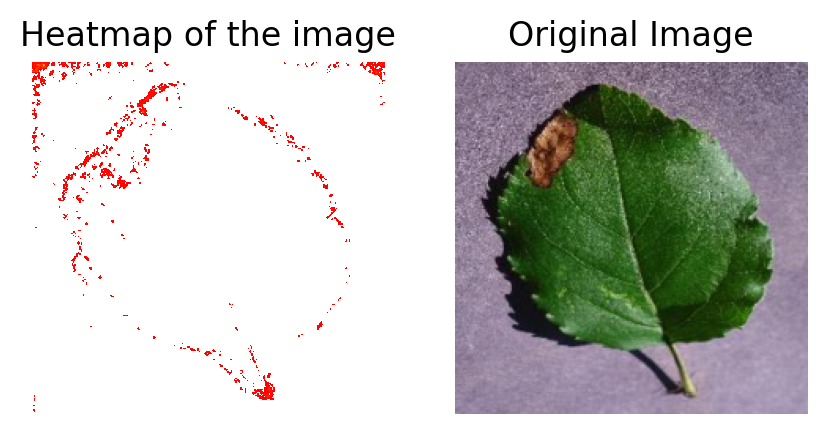

In [70]:
img = cv2.imread('/content/drive/MyDrive/Plant Leaf/Diseases/Plant/Without Augmentation/Apple___Black_rot/image (127).JPG')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Convert NumPy array to PIL image
img_pil = Image.fromarray(img_rgb)
inp_img = transform1(img_pil)
inp_img = inp_img.unsqueeze(0)

plot_image_sensitivity(inp_img,w,model_new)

### 4.3 Discussion

Insufficiently Good Pretrained Neural Network:

Issue: The pretrained model might not perform well in detecting plant diseases because it was trained on a dataset that differs significantly from plant disease images. This lack of specificity can lead to poor generalization to the task of identifying diseased regions in plant images.

Solution:
Fine-tune the pretrained model.
Using a model that is specific to plant disease detection.
Consider using a different neural network architecture that has been proven to work well for detecting diseases in plant image.

Presence of Non-Diseased Spots in the Dataset:

Issue: During the dataset collection process, non-diseased spots or areas on the leaves, such as natural variations, shadows, or other imperfections, might be present. These can lead to the neural network making "Clever Hans" errors—correct predictions for the wrong reasons—where the model misinterprets these spots as signs of disease.

Solution:
Data Annotation: Ensure accurate and detailed annotation of the dataset, distinguishing between actual diseased areas and benign spots.
Expert Review: Have plant disease experts review the annotated dataset to confirm that only true diseased regions are labeled as such.